dataset: Salesforce/wikitext/wikitext-103-raw-v1

model: pythia

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import torch
import datasets
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.modeling_outputs import CausalLMOutputWithPast

from tqdm import tqdm

In [2]:
from torch.nn import CrossEntropyLoss

class MemoryCell(torch.nn.Module):
    def __init__(self, base_model, num_mem_tokens, memory_dim):
        super().__init__()
        self.model = base_model
        self.memory_dim = memory_dim
        self.num_mem_tokens = num_mem_tokens
        for n, p in self.model.named_parameters():
            p.requires_grad = False
        self.create_memory()

    def create_memory(self):
        embeddings = self.model.get_input_embeddings()
        memory_params = torch.randn((self.num_mem_tokens, self.memory_dim)) * embeddings.weight.data.std()
        self.register_parameter('memory', torch.nn.Parameter(memory_params, requires_grad=True))
        self.read_memory_position = range(self.num_mem_tokens)

    def set_memory(self, input_shape):
        memory = self.memory.repeat(input_shape[0], 1, 1)
        return memory

    def forward(self, input_ids, memory_state=None, **kwargs):
        if memory_state is None:
            memory_state = self.set_memory(input_ids.shape)

        seg_kwargs = self.process_input(input_ids, memory_state, **kwargs)
        out = self.model(**seg_kwargs)
        out, new_memory_state = self.process_output(out, **kwargs)

        # todo: allow labels to be passed, could be used for masking
        labels = input_ids
        logits = out.logits
        labels = labels.to(logits.device)
        shift_logits = logits[:, :-1, :].contiguous()
        labels = labels[:, 1:].contiguous()
        loss_fct = CrossEntropyLoss()
        out.loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), labels.view(-1))

        return out, new_memory_state
    
    def generate(self, input_ids, memory_state, attention_mask, **generate_kwargs):
        if memory_state is None:
            memory_state = self.set_memory(input_ids.shape)

        seg_kwargs = self.process_input(input_ids, memory_state, attention_mask=attention_mask)
        out = self.model.generate(inputs_embeds=seg_kwargs['inputs_embeds'], attention_mask=seg_kwargs['attention_mask'], **generate_kwargs)
        return out

    def process_input(self, input_ids, memory_state, **kwargs):
        mem_kwargs = dict(**kwargs)

        inputs_embeds = kwargs.get('inputs_embeds')
        if inputs_embeds is None:
            inputs_embeds = self.model.get_input_embeddings()(input_ids)
        inputs_embeds = torch.cat([memory_state, inputs_embeds], dim=1)

        mem_kwargs['input_ids'] = None
        mem_kwargs['inputs_embeds'] = inputs_embeds
        if kwargs.get('attention_mask') is not None:
            mem_kwargs['attention_mask'] = self.pad_attention_mask(kwargs['attention_mask'], inputs_embeds.shape)
        mem_kwargs['output_hidden_states'] = True
        return mem_kwargs
    
    def pad_attention_mask(self, attention_mask, shape):
        if self.num_mem_tokens in {0, None}:
            return attention_mask
        else:
            mask = torch.ones(*shape[:2], dtype=torch.int64).to(attention_mask.device)
            mask[:, self.num_mem_tokens:] = attention_mask
            return mask
    
    def process_output(self, model_outputs, **kwargs):
        if self.num_mem_tokens not in {0, None}:
            out = CausalLMOutputWithPast()
            # take read memory here
            memory_state = model_outputs.hidden_states[-1][:, self.num_mem_tokens:]
            out['logits'] = model_outputs.logits[:, self.num_mem_tokens:]
            
            if kwargs.get('output_hidden_states'):
                out['hidden_states'] = [lh[:, self.num_mem_tokens:] for lh in model_outputs.hidden_states]
            if kwargs.get('output_attentions'):
                out['attentions'] = model_outputs['attentions']
        else:
            memory_state = None
            out = model_outputs
            
        return out, memory_state

In [3]:
# N mem tokens per 1 sample
# model takes 1

In [4]:
# ds = datasets.load_dataset('deepmind/pg19')
# ds

In [5]:
# todo: check labels and input ids
# todo: run training on different lengths
# todo: compare loss for orig model on text vs model with 
# todo: add per-token accuracy metric
# todo: add linear layer? it will add additional params, but! may help to stabilize training

In [7]:
import random
from nltk import sent_tokenize
# random.seed(144)

# Function to get a random chunk from a text with a minimum chunk size
def get_random_chunk(text, min_chunk_size):
    text = ' '.join(text.split())
    sentences = sent_tokenize(text)
    if len(sentences) < min_chunk_size:
        return ' '.join(sentences)  # Return the entire text if it's shorter than min_chunk_size
    n_words = 0
    while not (n_words < 25000 and n_words > 12000):
        max_start = len(sentences) - min_chunk_size
        start = random.randint(0, max_start)
        end = random.randint(start + min_chunk_size, len(sentences))
        chunk = ' '.join(sentences[start:end])
        n_words = len(chunk.split())
    return chunk

# Sample 10 random chunks from texts
texts = []
min_chunk_size = 10  # Set the minimum chunk size (in sentences)
for _ in tqdm(range(1000)):
    # Choose a random text from the validation set
    n_words = 0
    while n_words < 12000:
        text = random.choice(ds['validation'])['text']
        n_words = len(text.split())
    # Get a random chunk from this text with the minimum size
    chunk = get_random_chunk(text, min_chunk_size)
    texts.append(chunk)

for t in texts[:10]:
    print(t[:100])    
    print(f"Number of words in the sample: {len(t.split())}")
    print('----------')

100%|██████████| 1000/1000 [02:40<00:00,  6.24it/s]

'Let us stay here,' she exclaimed. 'The one room is as good as the other for what we have to talk ab
Number of words in the sample: 14391
----------
These lobsters don't realize that Jonesy's fast one would pass right through a batter without pausin
Number of words in the sample: 16530
----------
It certainly was not relief that he felt on discovering that she was paying no attention whatever to
Number of words in the sample: 15784
----------
Down to 1765 the duty imposed was only one penny, but as newspapers grew in influence the restrainin
Number of words in the sample: 14113
----------
And what was, perhaps, more extraordinary, though interrupted in the progress of his calculations, a
Number of words in the sample: 14564
----------
Oh, remember prayer is the great means of spiritual improvement, and guard as you would against a wi
Number of words in the sample: 20424
----------
Bonaparte could not well afford another direct attack, with its attendant losses, and strove to turn
Numbe

In [6]:
import pandas as pd
# df = pd.DataFrame({'text': texts})
# df.to_csv('pg19_valid_1k_chunks.csv')
df = pd.read_csv('pg19_valid_1k_chunks.csv', index_col=0)
df.head()

,text
0,"'Let us stay here,' she exclaimed. 'The one ro..."
1,These lobsters don't realize that Jonesy's fas...
2,It certainly was not relief that he felt on di...
3,Down to 1765 the duty imposed was only one pen...
4,"And what was, perhaps, more extraordinary, tho..."


In [9]:
from torch.optim import AdamW
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import torch
import pickle
from nltk import sent_tokenize

device = 'cuda'
dtype = torch.float32
use_flash_attention_2 = False
# model_name = 'princeton-nlp/Sheared-LLaMA-1.3B'
model_name = 'EleutherAI/pythia-160m'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def calculate_accuracy(logits, labels):
    # bs = 1
    shift_logits = logits[:, :-1, :]
    labels = labels[:, 1:]
    predictions = torch.argmax(shift_logits, dim=-1)
    correct = (predictions == labels).float()
    # all correct
    return (correct.sum() == correct.numel()).item()

def calculate_token_accuracy(logits, labels):
    # bs = 1
    shift_logits = logits[:, :-1, :]
    labels = labels[:, 1:]
    predictions = torch.argmax(shift_logits, dim=-1)
    correct = (predictions == labels).float()
    return correct.mean().item()

def run_single_experiment(N_mem_tokens, text_sample, max_length, num_iterations=50, sample_idx=None, run_idx=None):
    # split text sample on two parts: prefix and main text
    sentences = sent_tokenize(text_sample)
    prefix_text = ' '.join(sentences[:len(sentences)//2])
    suffix_text = ' '.join(sentences[len(sentences)//2:])

    inp = tokenizer(suffix_text, max_length=max_length, truncation=True, return_tensors='pt').to(device)
    
    model = AutoModelForCausalLM.from_pretrained(model_name, use_flash_attention_2=use_flash_attention_2)
    model.to(device)

    with torch.cuda.amp.autocast(dtype=dtype):
        with torch.no_grad():
            orig_output = model(**inp, labels=inp['input_ids'])
            orig_loss = orig_output.loss.item()
            orig_accuracy = calculate_accuracy(orig_output.logits, inp['input_ids'])
            orig_token_accuracy = calculate_token_accuracy(orig_output.logits, inp['input_ids'])

    model = AutoModelForCausalLM.from_pretrained(model_name, use_flash_attention_2=use_flash_attention_2)
    model_with_memory = MemoryCell(model, N_mem_tokens, model.config.hidden_size)
    model_with_memory.to(device)
    
    opt = AdamW(model_with_memory.parameters(), lr=1e-2, weight_decay=0.01, betas=(0.9, 0.9))
    
    desc = f"Training (N_mem_tokens={N_mem_tokens}, max_length={max_length}"
    if sample_idx is not None:
        desc += f", sample={sample_idx}"
    if run_idx is not None:
        desc += f", run={run_idx}"
    desc += f"), no_mem_loss={orig_loss:.4f}, no_mem_token_acc={orig_token_accuracy:.4f}"
    progress_bar = tqdm(range(num_iterations), desc=desc, disable=False)
    
    losses = []
    accuracies = []
    token_accuracies = []
    best_loss = float('inf')
    best_accuracy = 0
    best_token_accuracy = 0
    best_memory_params = None
    for _ in progress_bar:
        with torch.cuda.amp.autocast(dtype=dtype):
            out, mem = model_with_memory(**inp)
            loss = out.loss
            accuracy = calculate_accuracy(out.logits, inp['input_ids'])
            token_accuracy = calculate_token_accuracy(out.logits, inp['input_ids'])
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        current_loss = loss.item()
        losses.append(current_loss)
        accuracies.append(accuracy)
        token_accuracies.append(token_accuracy)
        
        if current_loss < best_loss:
            best_loss = current_loss
            best_accuracy = accuracy
            best_token_accuracy = token_accuracy
            best_memory_params = model_with_memory.memory.data.cpu().numpy()

        progress_bar.set_postfix(loss=f"{current_loss:.4f}", best_loss=f"{best_loss:.4f}", best_acc=f"{best_accuracy:.4f}", best_token_acc=f"{best_token_accuracy:.4f}")
        
        if best_accuracy == 1.0:
            break

    return {
        'losses': losses,
        'accuracies': accuracies,
        'token_accuracies': token_accuracies,
        'original_loss': orig_loss,
        'original_accuracy': orig_accuracy,
        'original_token_accuracy': orig_token_accuracy,
        'best_memory_params': best_memory_params,
        'best_loss': best_loss,
        'best_accuracy': best_accuracy,
        'best_token_accuracy': best_token_accuracy,
        'max_length': max_length,
        'n_mem_tokens': N_mem_tokens,
    }

N_mem_tokens_list = [1]#, 2, 4, 8, 16, 32, 64, 128]
max_lengths = [128] #[8, 16, 32, 64]# 128, 256, 512, 1024, 1568]
all_results = {}
num_runs = 1

samples = df['text'][:50]
num_iterations = 5000

for max_length in max_lengths:
    all_results = {}
    for N_mem_tokens in N_mem_tokens_list:
        aggregated_results = []

        for sample_idx, sample in enumerate(samples):
            for run in range(num_runs):
                result = run_single_experiment(N_mem_tokens, sample, max_length, num_iterations, sample_idx, run)
                aggregated_results += [result]

        all_results[N_mem_tokens] = aggregated_results
    # pickle.dump(all_results, open(f'{model_name.split("/")[1]}_results_len_{max_length}.pkl', 'wb'))

Training (N_mem_tokens=1, max_length=128, sample=0, run=0), no_mem_loss=3.4402, no_mem_token_acc=0.3071:  88%|████████▊ | 4403/5000 [01:34<00:12, 46.64it/s, best_acc=0.0000, best_loss=0.5244, best_token_acc=0.9213, loss=0.5393]


KeyboardInterrupt: 

In [22]:
all_results

{1: {}}

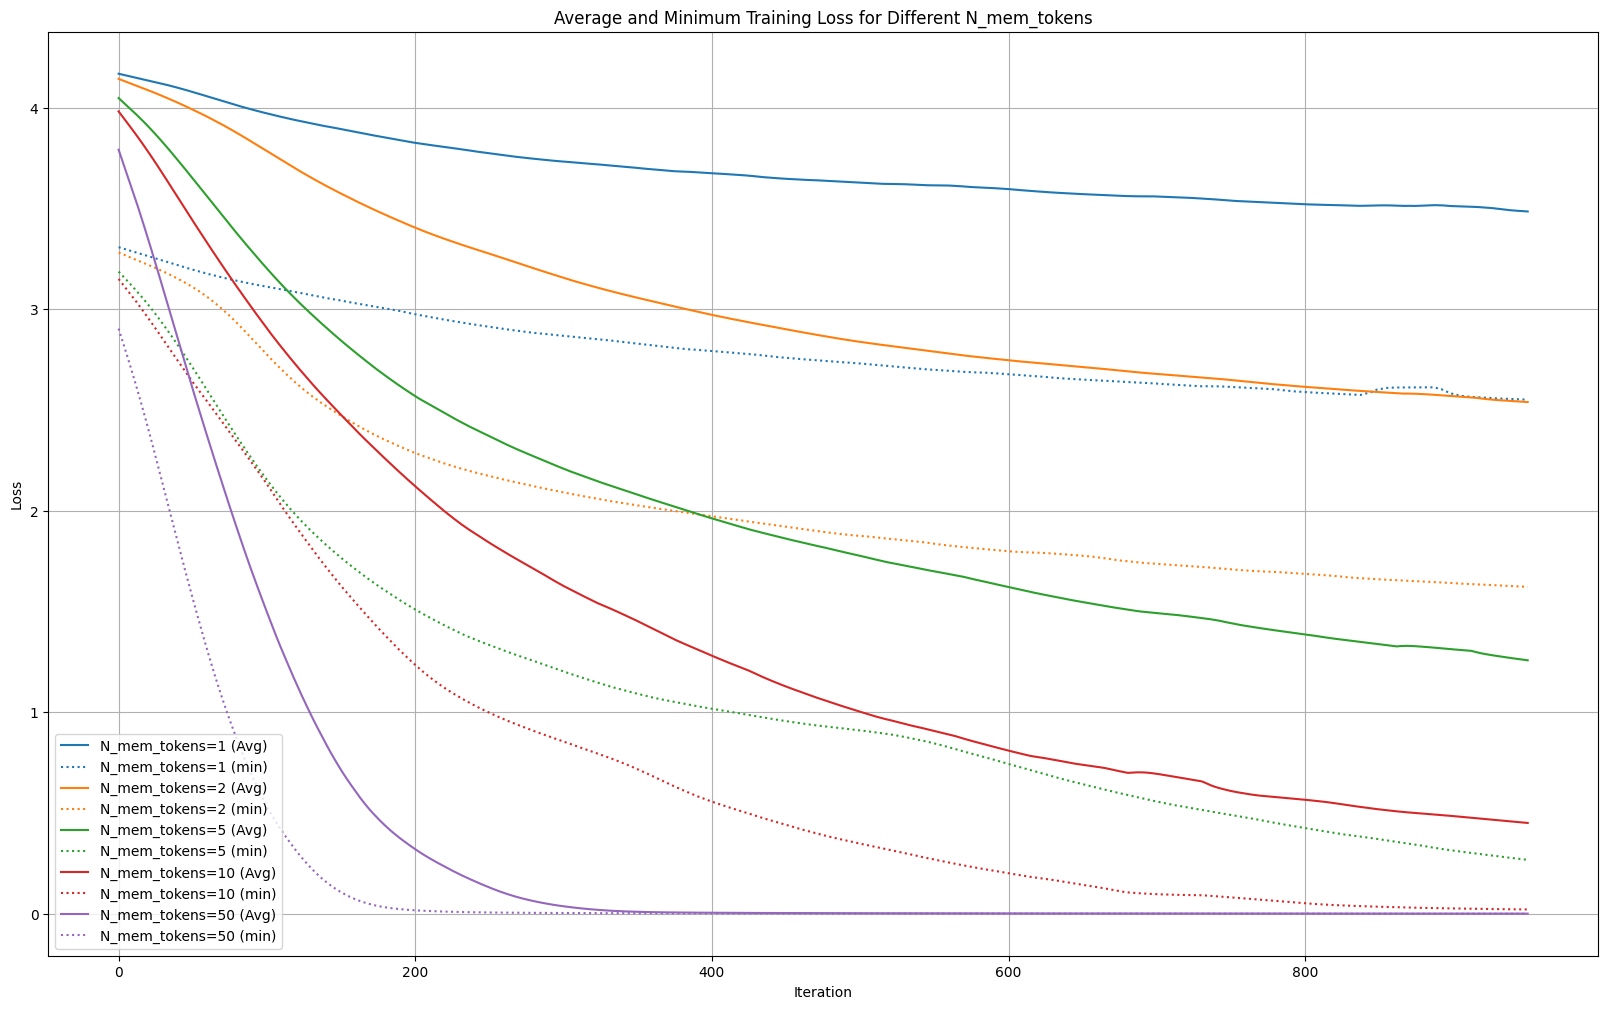

In [32]:
# Calculate average losses over 3 runs
avg_losses = {N: np.mean(runs, axis=0) for N, runs in all_losses.items()}

# Calculate minimum losses over 3 runs
min_losses = {N: np.min(runs, axis=0) for N, runs in all_losses.items()}

# Define a color map for different N_mem_tokens
colors = {N: plt.cm.tab10(i) for i, N in enumerate(avg_losses.keys())}

# Define window size for smoothing
window_size = 50

# Function to smooth the data using a moving average
def smooth(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Plot average losses for all runs
plt.figure(figsize=(20, 12))

# Plot smoothed average and minimum losses
for N_mem_tokens in avg_losses.keys():
    color = colors[N_mem_tokens]
    smoothed_avg = smooth(avg_losses[N_mem_tokens], window_size)
    smoothed_min = smooth(min_losses[N_mem_tokens], window_size)
    
    plt.plot(smoothed_avg, color=color, label=f'N_mem_tokens={N_mem_tokens} (Avg)')
    # plt.plot(min_losses[N_mem_tokens], color=color, linestyle='dotted', label=f'N_mem_tokens={N_mem_tokens} (Min)')
    plt.plot(smoothed_min, color=color, linestyle='dotted', label=f'N_mem_tokens={N_mem_tokens} (min)')

plt.title('Average and Minimum Training Loss for Different N_mem_tokens')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [31]:
import pickle
pickle.dump(all_results, open(f'all_results_{max_length}.pkl', 'wb'))
# all_results = pickle.load(open('all_results.pkl', 'rb'))

In [36]:
results = all_results[5][1]
print(results['best_loss'])
print(results['original_loss'])
results.keys()

0.9160189628601074
3.634707450866699


dict_keys(['losses', 'original_loss', 'best_memory_params', 'best_loss', 'text_sample', 'prefix_text', 'suffix_text', 'max_length', 'n_mem_tokens'])

In [37]:
prefix_text = results['prefix_text']
suffix_text = results['suffix_text']
max_length = results['max_length']

use_flash_attention_2 = False

suffix_inp = tokenizer(suffix_text, max_length=max_length, truncation=True, return_tensors='pt').to(device)

model = AutoModelForCausalLM.from_pretrained('EleutherAI/pythia-160m', use_flash_attention_2=use_flash_attention_2)
model.to(device)

with torch.cuda.amp.autocast(dtype=dtype):
    with torch.no_grad():
        loss = model(**suffix_inp, labels=suffix_inp['input_ids']).loss.item()
print(loss)

# model = AutoModelForCausalLM.from_pretrained('EleutherAI/pythia-160m', use_flash_attention_2=True)
# model_with_memory = MemoryCell(model, N_mem_tokens, model.config.hidden_size)
# model_with_memory.to(device)

3.634707450866699


In [38]:
tokenizer.decode(suffix_inp['input_ids'][0])

'But through all the changes in the activities of men, behind all their new combinations of forces "all things are the same forever and ever...." He remembered then that he had hurt Matilda, that she had resented his not being "like ordinary people," resented, that is, his acceptance of the unchanging order of things, his refusal to confuse surface change with the mighty ebb and flow of life. It was, he divined, that she had never reached up to any large idea and had never conceived of any life, individual or general, outside her own. To her, then, the life everlasting must mean _her_ life, and he regretted having used that phrase. She was concerned, then, entirely with her own existence--(and with his in so far as it overlapped hers)--and life to her was either "fun" or something unthinkable..... It seemed to him that he was near understanding her, and he loved her more than ever, and a rare warmth flooded his thoughts and they took on a life of their own, were bodied forth, and in a 

In [39]:
with torch.cuda.amp.autocast(dtype=dtype):
    with torch.no_grad():
        out = model.generate(suffix_inp['input_ids'], max_new_tokens=10)
        print(tokenizer.decode(out[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


But through all the changes in the activities of men, behind all their new combinations of forces "all things are the same forever and ever...." He remembered then that he had hurt Matilda, that she had resented his not being "like ordinary people," resented, that is, his acceptance of the unchanging order of things, his refusal to confuse surface change with the mighty ebb and flow of life. It was, he divined, that she had never reached up to any large idea and had never conceived of any life, individual or general, outside her own. To her, then, the life everlasting must mean _her_ life, and he regretted having used that phrase. She was concerned, then, entirely with her own existence--(and with his in so far as it overlapped hers)--and life to her was either "fun" or something unthinkable..... It seemed to him that he was near understanding her, and he loved her more than ever, and a rare warmth flooded his thoughts and they took on a life of their own, were bodied forth, and in a s

In [40]:
prefix_text = results['prefix_text']
suffix_text = results['suffix_text']
max_length = results['max_length']

tokenizer = AutoTokenizer.from_pretrained('EleutherAI/pythia-160m')
suffix_inp = tokenizer(suffix_text, max_length=max_length, truncation=True, return_tensors='pt').to(device)

model = AutoModelForCausalLM.from_pretrained('EleutherAI/pythia-160m', use_flash_attention_2=use_flash_attention_2)
model.to(device)

with torch.cuda.amp.autocast(dtype=dtype):
    with torch.no_grad():
        loss = model(**suffix_inp, labels=suffix_inp['input_ids']).loss.item()
print(loss)

# model = AutoModelForCausalLM.from_pretrained('EleutherAI/pythia-160m', use_flash_attention_2=True)
# model_with_memory = MemoryCell(model, N_mem_tokens, model.config.hidden_size)
# model_with_memory.to(device)

3.634707450866699


In [41]:
max_length

256

In [42]:
use_flash_attention_2 = False
dtype = torch.float32
device = 'cuda'

model = AutoModelForCausalLM.from_pretrained('EleutherAI/pythia-160m', use_flash_attention_2=use_flash_attention_2).to(device)

for i in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 1536]:
    suffix_inp = tokenizer(suffix_text, max_length=max_length, truncation=True, return_tensors='pt')
    prefix_inp = tokenizer(prefix_text, return_tensors='pt')
    prefix_inp['input_ids'] = prefix_inp['input_ids'][:,-i:]
    prefix_inp['attention_mask'] = prefix_inp['attention_mask'][:,-i:]

    # print(suffix_inp)
    # print(prefix_inp)
    for k in prefix_inp.keys():
        prefix_inp[k] = torch.cat([prefix_inp[k], suffix_inp[k]], dim=1)
    # print(prefix_inp)
    labels = prefix_inp['input_ids'].clone()
    labels[:, :i] = -100
    # print(labels)
    suffix_inp.to(device)
    prefix_inp.to(device)
    labels.to(device)
    with torch.cuda.amp.autocast(dtype=dtype):
        with torch.no_grad():
            loss = model(**prefix_inp, labels=labels).loss.item()
    print(i, loss)
# with torch.cuda.amp.autocast(dtype=dtype):
#     with torch.no_grad():
#         out = model.generate(prefix_inp['input_ids'], max_new_tokens=10)
#         print(tokenizer.decode(out[0]))

1 3.655163049697876
2 3.661891222000122
4 3.6676747798919678
8 3.6711347103118896
16 3.6639506816864014
32 3.6348066329956055
64 3.643930673599243
128 3.627079486846924
256 3.6045420169830322
512 3.42484974861145
1024 3.448737621307373
1536 3.463240146636963


In [62]:
prefix_text = results['prefix_text']
suffix_text = results['suffix_text']
max_length = results['max_length']

use_flash_attention_2 = False
dtype = torch.float32

tokenizer = AutoTokenizer.from_pretrained('EleutherAI/pythia-160m')
suffix_inp = tokenizer(suffix_text, max_length=max_length, truncation=True, return_tensors='pt').to(device)

model = AutoModelForCausalLM.from_pretrained('EleutherAI/pythia-160m', use_flash_attention_2=use_flash_attention_2)
model_with_memory = MemoryCell(model, results['n_mem_tokens'], model.config.hidden_size)
model_with_memory.memory.data = torch.tensor(results['best_memory_params'])
model_with_memory.to(device)

with torch.cuda.amp.autocast(dtype=dtype):
    with torch.no_grad():
        out, _ = model_with_memory(**suffix_inp)
        print(out.loss.item())


/home/jovyan/envs/py3.11_pt2_cu11.8/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


0.9168578386306763


In [52]:
results['best_loss']

0.9160189628601074

```
float32
1 4.411438465118408
2 4.416052341461182
4 4.444842338562012
8 4.399378776550293
16 4.369231224060059
32 4.173926830291748
64 4.217081546783447
128 4.1220197677612305
256 4.135775566101074
512 3.628185749053955
1024 3.7475156784057617
1536 3.7690014839172363

bfloat16
1 4.965087890625
2 5.0308837890625
4 4.994010925292969
8 4.731178283691406
16 4.603271484375
32 4.45550537109375
64 4.47918701171875
128 4.5911102294921875
256 4.351348876953125
512 3.8475265502929688
1024 4.161712646484375
1536 4.120735168457031

float16
1 4.438577651977539
2 4.476048469543457
4 4.463397026062012
8 4.411602020263672
16 4.388948440551758
32 4.133909225463867
64 4.206462860107422
128 4.146794319152832
256 4.116820335388184
512 3.6627678871154785
1024 3.7504215240478516
1536 3.803621768951416
```